# Synthetics and Multi-Table Relational Databases
* This notebook shows how to generate synthetic data directly from a mutli-table relational database
* The database used in the example below was first run through this [notebook](https://github.com/gretelai/public_research/blob/main/mutli-table-transforms/RDB_Transforms.ipynb) which is discussed in this [blog](https://gretel.ai/blog/transforms-and-multi-table-relational-databases) where transforms were used to de-identify PII.


## Capabilities
* This notebook can be run on any database SQLAlchemy supports such as Postgresql, SQLite or MySQL
* This notebook also contains instructions on how to create synthetic data when the relational tables exist in CSV files.
* It is not necessary to first use transforms on your data before using this notebook.
* Referential integriety of primary and foreign keys will remain intact
* User enters the ratio of synthetic records to original records that they would like produced. For example, 2 means you'd like the synthetic data to be twice the size of the original data. Alternatively, you can "subset" the database by using a value less than one. For example, a value of .5 means you'd like the synthetic data to be half the size of the original data.


## Limitations
* The primary and foreign keys in your database must be IDs
* Keys cannot be composite keys
* Cross table field correlations are not maintained.

## How to use this notebook on your own dataset
* Change the database connection string to refer to your database
* Alternatively, change the name and location of the CSV files where your data resides
* Specify the ratio of synthetic to original records you would like produced
* When viewing your data, change the table names used to your own table names
* When viewing the synthetic performance report, change the table name used to one of your own table names
* Modify the location where you'd like your final synthetic data to be stored

## Our ecommerce database
* Execute the below cell to see a diagram of the database we'll be using in this blueprint. The lines in the diagram show connections between primary and foreign keys

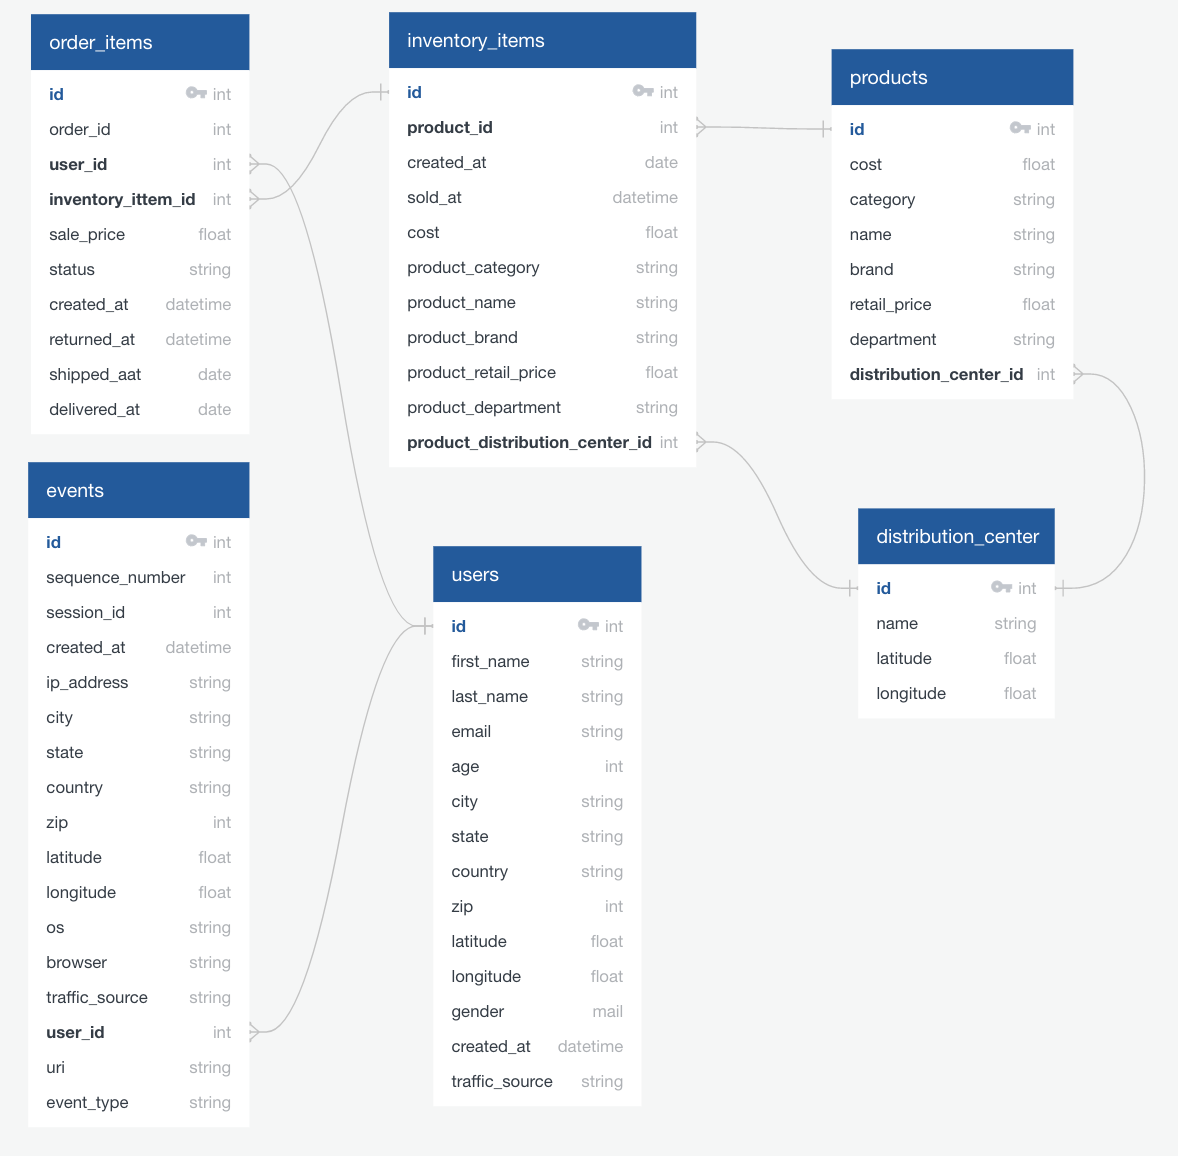

In [ ]:
from IPython.display import Image
Image("https://gretel-blueprints-pub.s3.us-west-2.amazonaws.com/rdb/ecommerce_db.png",width = 600, height = 600)

## Getting started

In [ ]:
!pip install pyyaml Faker pandas
!pip install SQLAlchemy
!pip install -U gretel-client

In [ ]:
# Specify your Gretel API key

from getpass import getpass
import pandas as pd
from gretel_client import configure_session, ClientConfig

pd.set_option('max_colwidth', None)

configure_session(ClientConfig(api_key=getpass(prompt="Enter Gretel API key"), 
                               endpoint="https://api.gretel.cloud"))

Enter Gretel API key········


In [ ]:
# Enter the ratio of synthetic records to original records you would like to produce
# Entering 1 means the synthetic data will be the same size as the original data
# Entering 2 means the synthetic data will be twice the size as the original data
# Entering .5 means the synthetic data will be half the size of the original data

synth_record_size_ratio = 2

## Gather data and schema relationships directly from a database
* For demonstration purposes, we'll first grab our ecommerce SQLite database from S3
* This notebook can be run on any database SQLAlchemy supports such as Postgresql or MySQL
* For example, if you have a postgres database, simply swap the `sqlite:///` connection string for a `postgres://` one in the `create_engine` command
* Using SQLAlchemy's reflection extension, we will crawl the schema, gather table data and produce a list of relationships by table primary key.

In [ ]:
from sqlalchemy import create_engine

!wget https://gretel-blueprints-pub.s3.amazonaws.com/rdb/ecom_xf.db
    
engine = create_engine("sqlite:///ecom_xf.db")

--2022-04-10 07:35:19--  https://gretel-blueprints-pub.s3.amazonaws.com/rdb/ecom_xf.db
Resolving gretel-blueprints-pub.s3.amazonaws.com (gretel-blueprints-pub.s3.amazonaws.com)... 52.92.131.201
Connecting to gretel-blueprints-pub.s3.amazonaws.com (gretel-blueprints-pub.s3.amazonaws.com)|52.92.131.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14020608 (13M) [binary/octet-stream]
Saving to: ‘ecom_xf.db’

ecom_xf.db          100%[===================>]  13.37M  6.91MB/s    in 1.9s    

2022-04-10 07:35:21 (6.91 MB/s) - ‘ecom_xf.db’ saved [14020608/14020608]



In [ ]:
# Gather the table data from the database

from sqlalchemy import MetaData, text

# This is the directory where we will temporarily store csv files for the transformer model
base_path = "./"

metadata = MetaData()
metadata.reflect(engine)

rdb_config = {}
rdb_config["table_data"] = {}
rdb_config["table_files"] = {}

for name, table in metadata.tables.items():
    df = pd.read_sql_table(name, engine)
    rdb_config["table_data"][name] = df
    filename = name + ".csv"
    df.to_csv(filename, index=False, header=True)
    rdb_config["table_files"][name] = filename


In [ ]:
# Extract primary/foriegn key relationshihps

from collections import defaultdict

rels_by_pkey = defaultdict(list)

for name, table in metadata.tables.items():
    for col in table.columns:
        for f_key in col.foreign_keys:
            rels_by_pkey[(f_key.column.table.name, f_key.column.name)].append((name, col.name))

list_of_rels_by_pkey = []

for p_key, f_keys in rels_by_pkey.items():
    list_of_rels_by_pkey.append([p_key] + f_keys)

rdb_config["relationships"] = list_of_rels_by_pkey

In [ ]:
# Extract each table's primary key

rdb_config["primary_keys"] = {}
for name, table in metadata.tables.items():
    for col in table.columns:
        if col.primary_key:
            rdb_config["primary_keys"][name] = col.name

## Alternatively, specify primary/foreign key relationships and locations of data csv files 
* This is an alternative to the above four cells that work directly with a database
* First, assign `base_path` to the directory where the csv files are located.
* Then, add a name/key pair for each table name/filename to `rdb_config["table_files"]`
* Add all primary keys for each table to `rdb_config["primary_keys"]`
* Add all foreign key/primary keys that connect to the same set under `rdb_config["relationships"]`

In [ ]:
# base_path is the directory where your csv files can be found
base_path = "https://gretel-blueprints-pub.s3.amazonaws.com/rdb/"

rdb_config = {
   "table_files": {
      "users": "users_transform.csv",

      "order_items": "order_items_transform.csv",
       
      "events": "events_transform.csv",
       
      "inventory_items": "inventory_items_transform.csv",  
       
      "products": "products_transform.csv",
       
      "distribution_center": "distribution_center_transform.csv"
   },

  # List the primary keys for each table
    
   "primary_keys": {
      "users": "id",

      "order_items": "id",
       
      "events": "id",
       
      "inventory_items": "id",  
       
      "products": "id",
       
      "distribution_center": "id"
   },

  # List the (table, field) relationships between primary and foreign keys 
    
   "relationships": [
          {("users","id"),
           ("order_items","user_id"),
           ("events","user_id")
          },         
       
          {("inventory_items","id"),
           ("order_items","inventory_item_id")  
          },         

          {("products","id"),
           ("inventory_items","product_id")
          },                

          {("distribution_center","id"),
           ("products","distribution_center_id"),
           ("inventory_items", "product_distribution_center_id")
          }             
   ]
}

# Gather the table data using the filenames entered above

rdb_config["table_data"] = {}
for table in rdb_config["table_files"]:
    filename = rdb_config["table_files"][table]
    df = pd.read_csv(filename)
    rdb_config["table_data"][table] = df

## Take a look at your data by joining two tables
* Note that every record in the table "order_items" matches to an entry in the table "users"
* An "inner" join will take the intersection of two tables

In [ ]:
pd.set_option("display.max_columns", None)

table_to_view1 = "order_items"
table_to_view2 = "users"
df1 = rdb_config["table_data"][table_to_view1]
df2 = rdb_config["table_data"][table_to_view2]

joined_data = df1.join(df2.set_index('id'), how='inner', on='user_id', lsuffix='_order_items', rsuffix='_users')
print("Number of records in order_items table is " + str(len(df1)))
print("Number of records in user table is " + str(len(df2)))
print("Number of records in joined data is " + str(len(joined_data)))

show_fields = ['id', 'user_id', 'inventory_item_id', 'sale_price', 'shipped_at', 'delivered_at', 'first_name', 'last_name', 'age', 'latitude', 'longitude']
joined_data.filter(show_fields).head()

Number of records in order_items table is 7882
Number of records in user table is 2197
Number of records in joined data is 7882


,id,user_id,inventory_item_id,sale_price,shipped_at,delivered_at,first_name,last_name,age,latitude,longitude
0,272,259,7965,8.00,None,None,Jason,Johnson,53,41.835673,-100.028364
1830,3046,259,10739,9.99,2018-05-11,2018-05-15,Jason,Johnson,53,41.835673,-100.028364
3735,4293,259,11986,64.00,2018-07-04,2018-07-07,Jason,Johnson,53,41.835673,-100.028364
1,309,290,8002,25.00,None,None,Brenda,Jenkins,26,43.272891,-102.183915
1451,5707,290,13400,9.54,2018-03-16,2018-03-21,Brenda,Jenkins,26,43.272891,-102.183915


## Compute the number of records required for each synthetic table

In [ ]:
synth_record_counts = {}
for table in rdb_config["table_data"]:
    df = rdb_config["table_data"][table]
    train_size = len(df)
    synth_size = train_size * synth_record_size_ratio
    synth_record_counts[table] = synth_size

## Prepare training data
* We will exclude primary and foriegn keys and rebuild them later

In [ ]:
table_fields = {}
table_fields_use = {}
for table in rdb_config["table_data"]:
    table_fields[table] = list(rdb_config["table_data"][table].columns)
    table_fields_use[table] = list(table_fields[table])

primary_keys_processed = []
for key_set in rdb_config["relationships"]:
    first = True
    for table_field_pair in key_set:
        table, field = table_field_pair
        if first:
            primary_keys_processed.append(table)
        table_fields_use[table].remove(field)
        
# Process the remaining primary keys
for table in rdb_config["primary_keys"]:
    if table not in primary_keys_processed:
        key_field = primary_keys[table]
        table_fields_use[table].remove(field)
        
training_data = {}
for table in rdb_config["table_data"]:
    table_train = rdb_config["table_data"][table].filter(table_fields_use[table])
    filename = "./" + table + ".csv"
    table_train.to_csv(filename, index=False, header=True)
    training_data[table] = filename

## Set up the training configs
* We'll assign each table the default training config
* We'll turn off the similarity privacy filter for the table "distribution_center" as it has only 10 training records
* Similarly, you can modify the other table configs to match the characteristics of that table (see [here](https://github.com/gretelai/gretel-blueprints/tree/main/config_templates/gretel/synthetics) for example configs that can be used).

In [ ]:
# Grab the default Synthetic Config file:
from smart_open import open
import yaml
import copy

with open("https://raw.githubusercontent.com/gretelai/gretel-blueprints/main/config_templates/gretel/synthetics/default.yml", 'r') as stream:
    default_config = yaml.safe_load(stream)
    
training_configs = {}
for table in rdb_config["table_data"]:
    training_configs[table] = copy.deepcopy(default_config)

training_configs["distribution_center"]['models'][0]['synthetics']['privacy_filters']['similarity'] = None

## Define functions to train models and generate synthetic data

In [ ]:
from gretel_client import projects
from gretel_client import create_project
from gretel_client.config import RunnerMode

def create_model(table:str, project):
    
    model = project.create_model_obj(model_config=training_configs[table])
    model.data_source = training_data[table]
    model.submit(upload_data_source=True)
    
    print("Model training started for " + table)
    
    return model
 
def generate_data(table:str, model):
    
    rh = model.create_record_handler_obj(training_data[table], params={"num_records": synth_record_counts[table]})
    rh.submit_cloud()
    
    print("Generation started for " + table)
    
    return rh    
        

## Set off training and generation and monitor progress
* Note, jobs will be set off in parallel then we will monitor them until completion

In [ ]:
# Initiate model training and generation

import pandas as pd

# model_progress will hold the status of each model during training and generation
model_progress = {}

# transformed_tables will hold the final transformed tables
synthetic_tables = {}

# Create a new project
project = create_project(display_name="rdb_synthetics6")

for table in rdb_config["table_files"]:
    model = create_model(table, project)
    model_progress[table] = {
                         "model": model,
                         "model_status": "pending",
                         "record_handler": "",
                         "record_handler_status": "",
                         }        
        
# Monitor model progression

more_to_do = True
no_errors = True
while more_to_do and no_errors:
    
    # Check status of training
    more_to_do = False
    for table in model_progress:
        status = model_progress[table]["model_status"]
        if (status == 'created') or (status == 'pending') or (status == "active"):
            more_to_do = True
            model = model_progress[table]["model"]
            model._poll_job_endpoint()
            status = model.__dict__['_data']['model']['status']
            
            # If status is now complete, submit the generation job
            if status == 'completed':
                report = model.peek_report()
                sqs = report['synthetic_data_quality_score']['score']
                print_string = "Training completed for " + table + " with SQS score " + str(sqs)
                if sqs >= 80:
                    print(print_string + " (Excellent)")
                elif sqs >= 60:
                    print(print_string + " (Good)")
                elif sqs >= 40:
                    print(print_string + " (Moderate)")
                elif sqs >= 20:
                    print(print_string + " (Poor)")
                else:
                    print(print_string + " (Very Poor)")
                rh = generate_data(table, model)
                model_progress[table]["record_handler"] = rh
                model_progress[table]["record_handler_status"] = "pending"
                    
            model_progress[table]["model_status"] = status
                
        # If training status was already complete, check status of the generation job
        elif status == 'completed':
            
            status = model_progress[table]["record_handler_status"]
            if (status == 'created') or (status == 'pending') or (status == 'active'):
            
                rh = model_progress[table]["record_handler"]
                rh._poll_job_endpoint()
                status = rh.__dict__['_data']['handler']['status']
                
                # If generation is now complete, get the synthetic data
                if status == 'completed':
                    df = pd.read_csv(rh.get_artifact_link("data"), compression='gzip')
                    synthetic_tables[table] = df
                    model_progress[table]["record_handler_status"] = status
                    print("Generation completed for " + table)
                    
                elif status != 'error':
                    more_to_do = True
                
                else:
                    print("\nGeneration for " + table + " ended in error")
                    no_errors = False
                    
            model_progress[table]["record_handler_status"] = status
                
        elif status == 'error':
            print("\nTraining for " + table + " ended in error")
            model_progress[table]["model_status"] = status
            no_errors = False
 
if no_errors:
    print("\nModel training and initial generation all complete!")

Model training started for distribution_center
Model training started for events
Model training started for users
Model training started for inventory_items
Model training started for products
Model training started for order_items
Training completed for distribution_center with SQS score 68 (Good)
Generation started for distribution_center
Generation completed for distribution_center
Training completed for order_items with SQS score 85 (Excellent)
Generation started for order_items
Training completed for users with SQS score 89 (Excellent)
Generation started for users
Training completed for inventory_items with SQS score 85 (Excellent)
Generation started for inventory_items
Generation completed for order_items
Generation completed for users
Generation completed for inventory_items
Training completed for events with SQS score 87 (Excellent)
Generation started for events
Training completed for products with SQS score 85 (Excellent)
Generation started for products
Generation completed fo

## Create synthetic primary keys
* Primary key ids will be replaced by a unique new id in the synthetic data

In [ ]:
synth_primary_keys = {}
for table in rdb_config["table_data"]:
    synth_size = synth_record_counts[table]
    new_key = [i for i in range(synth_size)]
    synth_primary_keys[table] = new_key
    
for table in rdb_config["primary_keys"]:
    field = rdb_config["primary_keys"][table]
    df = synthetic_tables[table]
    key = synth_primary_keys[table]
    # Sanity check the new synthetic df and the primary key match up in size
    table_len = len(df)
    key_use = key[0:table_len]
    df[field] = key_use
    synthetic_tables[table] = df
    

In [ ]:
# THIS IS OLD, REMOVE IF DON"T NEED

synth_foreign_keys = {}
for table in rdb_config["table_data"]:
    synth_foreign_keys[table] = {}

for key_set in rdb_config["relationships"]:
    print(key_set)
    # The first table/field pair is the primary key
    first = True
    for table_field_pair in key_set:
        table, field = table_field_pair
        print("Table: " + table + " Field: " + field)
        if first:
            primary_key_values = synth_primary_keys[table]
            first = False
            print("First is true")
        else:
            # Find the average number of records with the same foreign key value 
            synth_size = synth_record_counts[table]
            avg_cnt_key = int(synth_size / len(primary_key_values))
            print("synth_size: " + str(synth_size) + " primary key cnt: " + str(len(primary_key_values)) + " avg_cnt_key: " + str(avg_cnt_key))
            key_values = []
            key_cnt = 0
            # Now recreate the foreign key values using the primary key values while
            # preserving the avg number of records with the same foreign key value
            for i in range(len(primary_key_values)):
                for j in range(avg_cnt_key):
                    key_values.append(i)
                    key_cnt += 1
            i = 0
            while key_cnt < synth_size:
                key_values.append(i)
                key_cnt += 1
                i += 1
            random.shuffle(key_values)
            synth_foreign_keys[table][field] = key_values
            

## Create synthetic foreign keys
* For each table with a foreign key, we'll find the average number of records with the same foreign key value in the training data
* We'll then recreate the foreign key values using the new primary key values while maintaining this ratio

In [ ]:
import random

synth_foreign_keys = {}
for table in rdb_config["table_data"]:
    synth_foreign_keys[table] = {}

for key_set in rdb_config["relationships"]:
    # The first table/field pair is the primary key
    first = True
    for table_field_pair in key_set:
        table, field = table_field_pair
        if first:
            primary_key_values = synth_primary_keys[table]
            first = False
        else:
            # Find the average number of records with the same foreign key value 
            synth_size = synth_record_counts[table]
            avg_cnt_key = int(synth_size / len(primary_key_values))
            key_values = []
            key_cnt = 0
            # Now recreate the foreign key values using the primary key values while
            # preserving the avg number of records with the same foreign key value
            for i in range(len(primary_key_values)):
                for j in range(avg_cnt_key):
                    key_values.append(i)
                    key_cnt += 1
            i = 0
            while key_cnt < synth_size:
                key_values.append(i)
                key_cnt += 1
                i += 1
            random.shuffle(key_values)
            synth_foreign_keys[table][field] = key_values
            
for table in synth_foreign_keys:
    df = synthetic_tables[table]
    table_len = len(df)
    for field in synth_foreign_keys[table]:
        key = synth_foreign_keys[table][field]
        # Sanity check the new synthetic df and the foreign key match up in size
        key_use = key[0:table_len]
        df[field] = key_use
    synthetic_tables[table] = df

## Verify the size of the new synthetic tables

In [ ]:
for table in synthetic_tables:
    new_len = len(synthetic_tables[table])
    orig_len = len(rdb_config["table_data"][table])
    ratio = new_len / orig_len
    print("Table " + table + ": Original record count: " + str(orig_len) + " New record count: " + str(new_len) + " Ratio: " + str(ratio))

Table distribution_center: Original record count: 10 New record count: 20 Ratio: 2.0
Table order_items: Original record count: 7882 New record count: 15764 Ratio: 2.0
Table users: Original record count: 2197 New record count: 4394 Ratio: 2.0
Table inventory_items: Original record count: 7882 New record count: 15764 Ratio: 2.0
Table products: Original record count: 29120 New record count: 58240 Ratio: 2.0
Table events: Original record count: 48886 New record count: 97772 Ratio: 2.0


## View the synthetic data
* We'll again join the order_items and users tables

In [ ]:
pd.set_option("display.max_columns", None)

table_to_view1 = "order_items"
table_to_view2 = "users"
df1 = synthetic_tables[table_to_view1]
df2 = synthetic_tables[table_to_view2]

joined_data = df1.join(df2.set_index('id'), how='inner', on='user_id', lsuffix='_order_items', rsuffix='_users')
print("Number of records in order_items table is " + str(len(df1)))
print("Number of records in user table is " + str(len(df2)))
print("Number of records in joined data is " + str(len(joined_data)))

show_fields = ['id', 'user_id', 'inventory_item_id', 'sale_price', 'shipped_at', 'delivered_at', 'first_name', 'last_name', 'age', 'latitude', 'longitude']
joined_data.filter(show_fields).head()

Number of records in order_items table is 15764
Number of records in user table is 4394
Number of records in joined data is 15764


,id,user_id,inventory_item_id,sale_price,shipped_at,delivered_at,first_name,last_name,age,latitude,longitude
0,0,3403,12369,48.0,2018-05-12,2018-05-16,Edward,Allen,24,43.296965,-102.19001
6102,6102,3403,4742,10.0,2020-09-15,2020-09-22,Edward,Allen,24,43.296965,-102.19001
12498,12498,3403,12708,23.0,2019-10-29,2019-11-02,Edward,Allen,24,43.296965,-102.19001
1,1,3229,3813,15.0,2019-04-16,2019-04-20,Danielle,Clark,66,41.634039,-100.30562
803,803,3229,13099,15.0,2019-08-11,2019-08-16,Danielle,Clark,66,41.634039,-100.30562


## View the synthetic performance reports

In [ ]:
# Generate report that shows the statistical performance between the training and synthetic data

from smart_open import open
from IPython.core.display import display, HTML

# Change table_name to any of the tables in your relational database
table_name = "users"
display(HTML(data=open(model_progress[table_name]["model"].get_artifact_link("report")).read(), metadata=dict(isolated=True)))

## Save the transformed data back into an SQLite database

In [ ]:
!cp ecom_xf.db ecom_synth.db
engine_synth = create_engine("sqlite:///ecom_synth.db")

with engine_synth.connect() as conn:

    for table in synthetic_tables:
        command = "DELETE FROM " + table
        conn.execute(command)
        synthetic_tables[table].to_sql(table, con=conn, if_exists='append', index=False)

## Alternatively save the transformed data back into a Postgres database

In [ ]:
from sqlalchemy import text

with engine.connect() as conn:
    result = conn.execute(text("create database ecom_synth with template ecom_xf"))
    engine_synth = create_engine("postgres:///ecom_synth.db")
    for table in synthetic_tables:
        synthetic_tables[table].to_sql(table, con=engine_synth, if_exists='replace', index=False)

    conn.commit()

## Alterntively, save the transformed content into CSV files

In [ ]:
# Change final_dir to be the location where you'd like your csv files saved
final_dir = "./"
for table in synthetic_tables:
    df = synthetic_tables[table]
    filename = final_dir + table + '_synth.csv'
    df.to_csv(filename, index=False, header=True)